# Task 3: News Sentiment and Stock Price Correlation Analysis


In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from textblob import TextBlob

# Import utility functions
from src.sentiment_analysis import analyze_headlines, aggregate_daily_sentiment
from src.correlation_analysis import calculate_returns, align_sentiment_returns, calculate_correlation_metrics

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

## Load and Prepare Data

In [2]:
# Load news data
NEWS_FILE_PATH = '../data/raw_analyst_ratings.csv'
try:
    news_df = pd.read_csv(NEWS_FILE_PATH)
    print(f"Loaded news data shape: {news_df.shape}")
except FileNotFoundError:
    print(f"News data file not found at {NEWS_FILE_PATH}")
    news_df = pd.DataFrame()

# Load stock data
STOCK_DATA_DIR = Path('../data/yfinance_data')
stock_dfs = {}

if STOCK_DATA_DIR.exists():
    for file in STOCK_DATA_DIR.glob('*.csv'):
        symbol = file.stem.upper()
        df = pd.read_csv(file)
        df['Date'] = pd.to_datetime(df['Date'])
        stock_dfs[symbol] = df
        print(f"Loaded {symbol} data with shape: {df.shape}")

Loaded news data shape: (1407328, 6)
Loaded AAPL_HISTORICAL_DATA data with shape: (10998, 9)
Loaded AMZN_HISTORICAL_DATA data with shape: (6846, 9)
Loaded GOOG_HISTORICAL_DATA data with shape: (5020, 9)
Loaded META_HISTORICAL_DATA data with shape: (2926, 9)
Loaded MSFT_HISTORICAL_DATA data with shape: (9672, 9)
Loaded NVDA_HISTORICAL_DATA data with shape: (6421, 9)
Loaded TSLA_HISTORICAL_DATA data with shape: (3545, 9)


## Sentiment Analysis

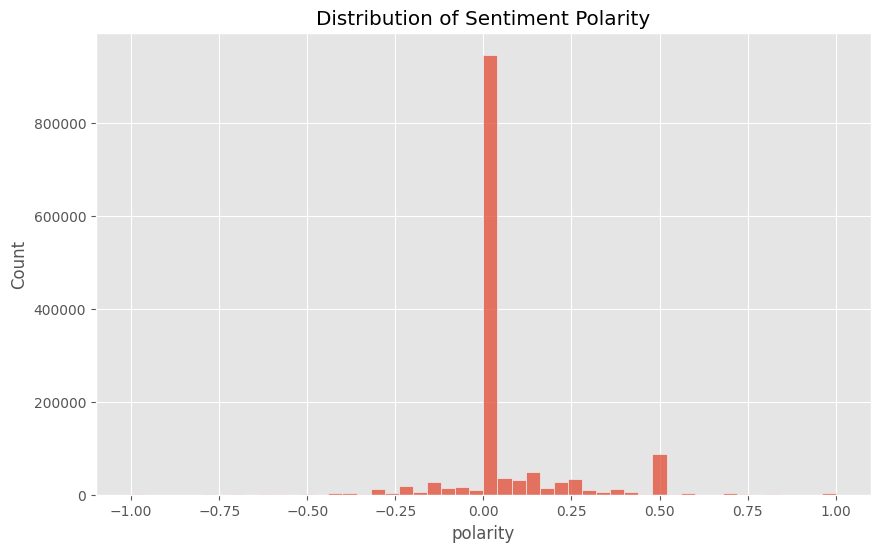

In [3]:
if not news_df.empty and 'headline' in news_df.columns:
    # Perform sentiment analysis
    sentiment_df = analyze_headlines(news_df['headline'].tolist())
    
    # Add dates and symbols if available
    sentiment_df['date'] = pd.to_datetime(news_df['date'],format="ISO8601")
    if 'symbol' in news_df.columns:
        sentiment_df['symbol'] = news_df['symbol'].str.upper()
    
    # Aggregate daily sentiment
    daily_sentiment = aggregate_daily_sentiment(
        sentiment_df,
        date_column='date',
        symbol_column_name='symbol' if 'symbol' in news_df.columns else None
    )
    
    # Plot sentiment distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=sentiment_df, x='polarity', bins=50)
    plt.title('Distribution of Sentiment Polarity')
    plt.show()

## Calculate Stock Returns

In [4]:
stock_returns = {}
for symbol, df in stock_dfs.items():
    # Calculate daily returns
    returns = calculate_returns(df['Close'])
    stock_returns[symbol] = pd.DataFrame({
        'date': df['Date'],
        'returns': returns
    }).set_index('date')
    
    print(f"\nReturns statistics for {symbol}:")
    print(stock_returns[symbol].describe())


Returns statistics for AAPL_HISTORICAL_DATA:
            returns
count  10997.000000
mean       0.001073
std        0.027895
min       -0.518692
25%       -0.012710
50%        0.000000
75%        0.014451
max        0.332280

Returns statistics for AMZN_HISTORICAL_DATA:
           returns
count  6845.000000
mean      0.001716
std       0.035429
min      -0.247661
25%      -0.013028
50%       0.000409
75%       0.014671
max       0.344714

Returns statistics for GOOG_HISTORICAL_DATA:
           returns
count  5019.000000
mean      0.001029
std       0.019318
min      -0.116091
25%      -0.007854
50%       0.000802
75%       0.010138
max       0.199915

Returns statistics for META_HISTORICAL_DATA:
           returns
count  2925.000000
mean      0.001260
std       0.024277
min      -0.263901
25%      -0.009598
50%       0.001077
75%       0.012652
max       0.296115

Returns statistics for MSFT_HISTORICAL_DATA:
           returns
count  9671.000000
mean      0.001091
std       0.021126
m

## Correlation Analysis

In [5]:
correlation_results = {}

for symbol, returns_df in stock_returns.items():
    try:
        # Get stock-specific sentiment if available
        if 'symbol' in daily_sentiment.columns:
            stock_sentiment = daily_sentiment[daily_sentiment['symbol'] == symbol]
        else:
            stock_sentiment = daily_sentiment
        
        # Align sentiment and returns data
        aligned_data = align_sentiment_returns(
            stock_sentiment,
            returns_df,
            'date',
            'Date'
        )
        
        # Calculate correlation metrics
        metrics = calculate_correlation_metrics(
            aligned_data['mean_polarity'],
            aligned_data['returns']
        )
        
        correlation_results[symbol] = metrics
        
        # Create scatter plot
        plt.figure(figsize=(10, 6))
        sns.regplot(data=aligned_data, x='mean_polarity', y='returns')
        plt.title(f'Sentiment vs Returns Correlation for {symbol}')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Returns')
        
        # Add correlation stats to plot
        plt.text(0.05, 0.95,
                 f"Pearson correlation: {metrics['pearson_correlation']:.3f}\n"
                 f"p-value: {metrics['pearson_p_value']:.3f}",
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8))
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing {symbol}: {str(e)}")
        correlation_results[symbol] = {'error': str(e)}


Error analyzing AAPL_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing AMZN_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing GOOG_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing META_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing MSFT_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing NVDA_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}
Error analyzing TSLA_HISTORICAL_DATA: Missing required columns in returns_df: {'Date'}


In [13]:
# Create summary DataFrame
summary_data = []
for symbol, metrics in correlation_results.items():
    if 'error' not in metrics:
        summary_data.append({
            'Symbol': symbol,
            'Pearson Correlation': metrics['pearson_correlation'],
            'P-value': metrics['pearson_p_value'],
            'Significant at 5%': metrics['pearson_p_value'] < 0.05,
            'Observations': metrics['n_observations']
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Pearson Correlation', ascending=False)
    print("\nCorrelation Analysis Summary:")
    print(summary_df)
    
    # Plot correlation heatmap for significant relationships
    significant_correlations = summary_df[summary_df['Significant at 5%']]
    if not significant_correlations.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=significant_correlations,
                    x='Symbol',
                    y='Pearson Correlation')
        plt.title('Significant Sentiment-Returns Correlations')
        plt.xticks(rotation=45)
        plt.show()